In [570]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [571]:
folder_path = "/Users/oas/Downloads/benchmarking_results"
# folder_path = "/Users/oas/Documents/VOD/vod/benchmarking_results"
files = [
    os.path.join(folder_path, file)
    for file in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, file))
]
files.sort()  # Sort the files by name
newest_file = files[-1]  # Pick the newest
print(newest_file)

/Users/oas/Downloads/benchmarking_results/2024-02-22-00-19-00.csv


In [572]:
df_results = pd.read_csv(newest_file)
df_results.shape

(108, 16)

In [573]:
df_results.query("Dataset == 'gist-960-euclidean' and ingesting_max != -1")  # ["Index parameters."].str[-40:]

,Unnamed: 0,Dataset,Index,Index parameters.,Server startup speed (s),Index build speed (s),Search speed avg. (ms),Search speed p95 (ms),Recall avg,Recall@1,Recall@10,Recall@100,ingesting_max,ingesting_mean,benchmarking_max,benchmarking_mean
54,54,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=128, ...","HNSW, M=16, ef_construction=128, ef_search=128...",31.089218,175.654355,194.317290,202.675008,0.000113,0.0000,0.0001,0.0010,2533.376,812.915200,4292.608,4281.736533
55,55,gist-960-euclidean,"index: faiss HNSW, M=32, ef_construction=128, ...","HNSW, M=32, ef_construction=128, ef_search=128...",30.409679,378.494433,267.847093,282.663590,0.000126,0.0000,0.0001,0.0010,4087.808,1161.921600,4411.392,4400.295869
57,57,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=256, ...","HNSW, M=16, ef_construction=256, ef_search=128...",29.611155,249.330119,199.281282,203.410447,0.000105,0.0000,0.0002,0.0011,629.400,410.100000,4287.488,4275.926710
58,58,gist-960-euclidean,"index: faiss HNSW, M=32, ef_construction=256, ...","HNSW, M=32, ef_construction=256, ef_search=128...",28.630100,436.757662,268.759941,292.169331,0.000129,0.0000,0.0002,0.0010,4045.824,1143.604800,4408.320,4396.925968
66,66,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=128, ...","HNSW, M=16, ef_construction=128, ef_search=128...",15.450955,328.333254,224.728841,228.195732,0.000130,0.0000,0.0000,0.0003,462.100,322.275000,1569.792,1546.206968
69,69,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=256, ...","HNSW, M=16, ef_construction=256, ef_search=128...",15.432074,396.452885,228.036092,234.834733,0.000152,0.0000,0.0000,0.0004,463.200,323.150000,1565.696,1555.654194
90,90,gist-960-euclidean,"index: milvus HNSW, M=16, ef_construction=128,...","HNSW, M=16, ef_construction=128, ef_search=128...",102.207064,653.902147,9858.027952,12038.590039,0.971829,0.9724,0.9810,0.9815,3050.576,1089.952159,NaN,NaN
91,91,gist-960-euclidean,"index: milvus HNSW, M=32, ef_construction=128,...","HNSW, M=32, ef_construction=128, ef_search=128...",101.395028,595.447718,11025.306249,12996.271735,0.982410,0.9803,0.9895,0.9899,2670.328,1013.404304,NaN,NaN
92,92,gist-960-euclidean,"index: milvus HNSW, M=64, ef_construction=128,...","HNSW, M=64, ef_construction=128, ef_search=128...",101.902125,616.643238,12479.849368,15000.471222,0.985749,0.9824,0.9911,0.9918,3120.812,1203.647382,NaN,NaN


In [574]:
df_results = df_results.query("Index != 'None'")  # ignore failed runs
df_results = df_results.query("benchmarking_mean != -1")  # ignore failed runs

In [575]:
# extract index information
df_results["IndexProvider"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[0]
df_results["IndexType"] = df_results.Index.str[7:].str.split(",").str[0].str.split(" ").str[1]

In [576]:
# extract search parameters from parameter string

df_hnsw_parameters = (df_results.query("IndexType == 'HNSW'")["Index parameters."]
    .str.replace("=", ", ")
    .str.split(", ", expand=True)[[2, 4, 6, 7, 8]]
)
df_hnsw_parameters.columns = ["M", "ef_construction", "ef_search", "Compression", "Metric"]

df_ivf_parameters = pd.DataFrame()
# TODO fix that this makes errors when no IVF are in benchmark
# df_ivf_parameters = (df_results.query("IndexType == 'IVF'")["Index parameters."]
#     .str.replace(",", "")
#     .str.replace("=", " ")
#     .str.split(" ", expand=True)[[2, 3, 4]]
# )
# df_ivf_parameters.columns = ["nPartitions", "Compression", "Metric"]
""

''

In [577]:
# add search parameters to df_results
df_parameters = df_hnsw_parameters.combine_first(df_ivf_parameters)
df_results = pd.concat((df_results, df_parameters), axis=1)

In [578]:
df_results.shape

(45, 23)

In [579]:
# df_results = df_results.dropna()

In [580]:
df_results.columns

Index(['Unnamed: 0', 'Dataset', 'Index', 'Index parameters.',
       'Server startup speed (s)', 'Index build speed (s)',
       'Search speed avg. (ms)', 'Search speed p95 (ms)', 'Recall avg',
       'Recall@1', 'Recall@10', 'Recall@100', 'ingesting_max',
       'ingesting_mean', 'benchmarking_max', 'benchmarking_mean',
       'IndexProvider', 'IndexType', 'M', 'ef_construction', 'ef_search',
       'Compression', 'Metric'],
      dtype='object')

In [581]:
import plotly.express as px
import plotly.graph_objects as go

# Your existing DataFrame and plot
fig = px.scatter(
    df_results,
    x="Recall avg",
    y="Search speed avg. (ms)",
    hover_data=["Index","ingesting_max","benchmarking_mean","Dataset"],
    color="IndexProvider",
    size=df_results["ingesting_max"],
    symbol="Dataset"
)

# # Adding a similar scatter plot but with semi-transparency and different size mapping
# fig.add_trace(
#     go.Scatter(
#         x=df_results["Recall avg"],
#         y=df_results["Search speed avg. (ms)"],
#         mode="markers",
#         marker=dict(
#             size=df_results["ingesting_max"] / 25,  # Size based on 'ingesting_max' column
#             opacity=0.1,  # Semi-transparent markers
#             # color=fig.data[0].marker.color,  # Use the same color as the first plot
#             # line=dict(color="MediumPurple", width=2),
#         ),
#         hoverinfo="text",  # You can customize hover info as needed
#         name="Ingesting max",
#     )
# )

fig.show()

In [582]:
df_results.query("Dataset == 'gist-960-euclidean'")

,Unnamed: 0,Dataset,Index,Index parameters.,Server startup speed (s),Index build speed (s),Search speed avg. (ms),Search speed p95 (ms),Recall avg,Recall@1,...,ingesting_mean,benchmarking_max,benchmarking_mean,IndexProvider,IndexType,M,ef_construction,ef_search,Compression,Metric
54,54,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=128, ...","HNSW, M=16, ef_construction=128, ef_search=128...",31.089218,175.654355,194.317290,202.675008,0.000113,0.0000,...,812.915200,4292.608,4281.736533,faiss,HNSW,16,128,128,None,L2
55,55,gist-960-euclidean,"index: faiss HNSW, M=32, ef_construction=128, ...","HNSW, M=32, ef_construction=128, ef_search=128...",30.409679,378.494433,267.847093,282.663590,0.000126,0.0000,...,1161.921600,4411.392,4400.295869,faiss,HNSW,32,128,128,None,L2
57,57,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=256, ...","HNSW, M=16, ef_construction=256, ef_search=128...",29.611155,249.330119,199.281282,203.410447,0.000105,0.0000,...,410.100000,4287.488,4275.926710,faiss,HNSW,16,256,128,None,L2
58,58,gist-960-euclidean,"index: faiss HNSW, M=32, ef_construction=256, ...","HNSW, M=32, ef_construction=256, ef_search=128...",28.630100,436.757662,268.759941,292.169331,0.000129,0.0000,...,1143.604800,4408.320,4396.925968,faiss,HNSW,32,256,128,None,L2
66,66,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=128, ...","HNSW, M=16, ef_construction=128, ef_search=128...",15.450955,328.333254,224.728841,228.195732,0.000130,0.0000,...,322.275000,1569.792,1546.206968,faiss,HNSW,16,128,128,SQ8,L2
69,69,gist-960-euclidean,"index: faiss HNSW, M=16, ef_construction=256, ...","HNSW, M=16, ef_construction=256, ef_search=128...",15.432074,396.452885,228.036092,234.834733,0.000152,0.0000,...,323.150000,1565.696,1555.654194,faiss,HNSW,16,256,128,SQ8,L2
90,90,gist-960-euclidean,"index: milvus HNSW, M=16, ef_construction=128,...","HNSW, M=16, ef_construction=128, ef_search=128...",102.207064,653.902147,9858.027952,12038.590039,0.971829,0.9724,...,1089.952159,NaN,NaN,milvus,HNSW,16,128,128,None,L2
91,91,gist-960-euclidean,"index: milvus HNSW, M=32, ef_construction=128,...","HNSW, M=32, ef_construction=128, ef_search=128...",101.395028,595.447718,11025.306249,12996.271735,0.982410,0.9803,...,1013.404304,NaN,NaN,milvus,HNSW,32,128,128,None,L2
92,92,gist-960-euclidean,"index: milvus HNSW, M=64, ef_construction=128,...","HNSW, M=64, ef_construction=128, ef_search=128...",101.902125,616.643238,12479.849368,15000.471222,0.985749,0.9824,...,1203.647382,NaN,NaN,milvus,HNSW,64,128,128,None,L2


In [583]:
df_plot = df_results.query("Compression == 'SQ8'")
plt.scatter(df_plot.nPartitions, df_plot["Search speed avg. (ms)"]/10, label="SQ8", c="red")
df_plot = df_results.query("Compression == 'PQ8'")
plt.scatter(df_plot.nPartitions, df_plot["Search speed avg. (ms)"]/10, label="PQ8")
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.xlabel("n partitions")
plt.ylabel("Mean search latency (ms)")
plt.legend()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'nPartitions'

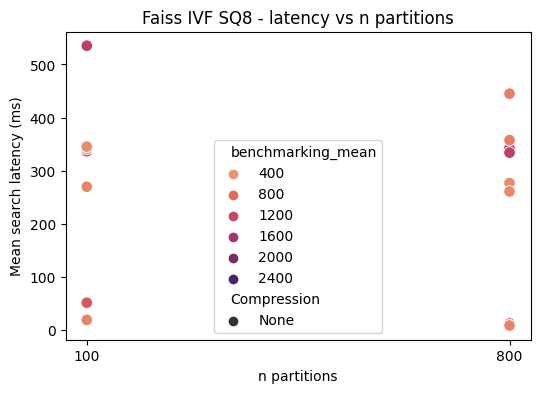

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.scatterplot(data=df_results, x="nPartitions", y="Search speed avg. (ms)", hue="benchmarking_mean", style="Compression", palette="flare", s=70)
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.xlabel("n partitions")
plt.ylabel("Mean search latency (ms)")
plt.show()

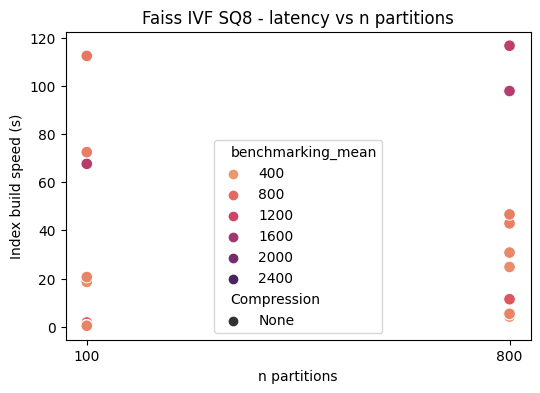

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_results,
    x="nPartitions",
    y="Index build speed (s)",
    hue="benchmarking_mean",
    style="Compression",
    palette="flare",
    s=70,
)
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.xlabel("n partitions")
plt.ylabel("Index build speed (s)")
plt.show()

In [ ]:
df_results.columns

Index(['Unnamed: 0', 'Dataset', 'Index', 'Index parameters.',
       'Server startup speed (s)', 'Index build speed (s)',
       'Search speed avg. (ms)', 'Search speed p95 (ms)', 'Recall avg',
       'Recall@1', 'Recall@10', 'Recall@100', 'ingesting_max',
       'ingesting_mean', 'benchmarking_max', 'benchmarking_mean',
       'IndexProvider', 'IndexType', 'Compression', 'M', 'Metric',
       'ef_construction', 'ef_search', 'nPartitions'],
      dtype='object')

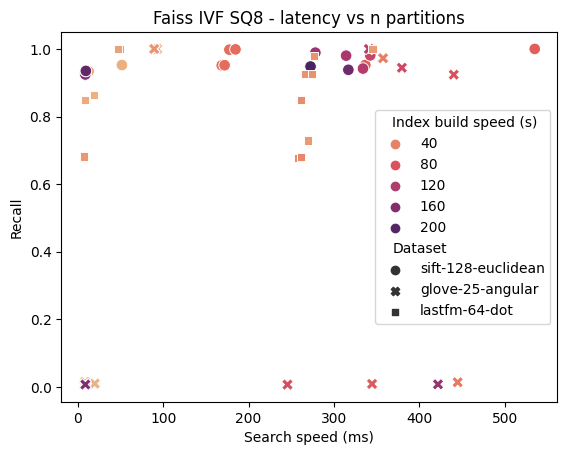

In [ ]:
import seaborn as sns

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_results,
    x="Search speed avg. (ms)",
    y="Recall avg",
    style="Dataset",
    hue="Index build speed (s)",
    palette="flare",
    s=70,
)
plt.title("Faiss IVF SQ8 - latency vs n partitions")
plt.ylabel("Recall")
plt.xlabel("Search speed (ms)")
plt.show()

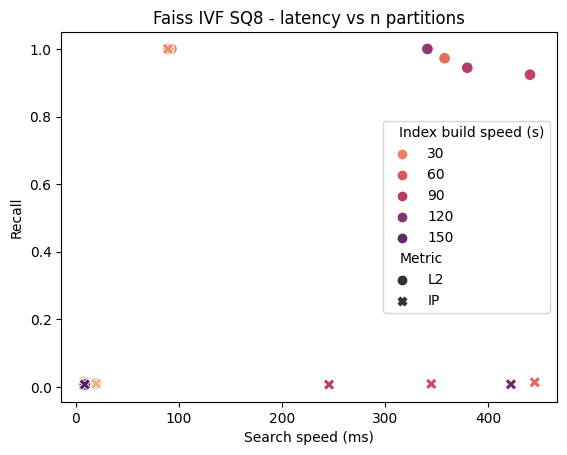

In [ ]:
df_plot = df_results.query("Dataset == 'glove-25-angular'")

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_plot,
    x="Search speed avg. (ms)",
    y="Recall avg",
    style="Metric",
    hue="Index build speed (s)",
    palette="flare",
    s=70,
)
plt.ylabel("Recall")
plt.xlabel("Search speed (ms)")
plt.show()

In [ ]:
df_results.query('Metric == "IP" and Dataset == "glove-25-angular"')

,Unnamed: 0,Dataset,Index,Index parameters.,Server startup speed (s),Index build speed (s),Search speed avg. (ms),Search speed p95 (ms),Recall avg,Recall@1,...,benchmarking_max,benchmarking_mean,IndexProvider,IndexType,Compression,M,Metric,ef_construction,ef_search,nPartitions
29,29,glove-25-angular,"index: qdrant HNSW, M=16, ef_construction=128,...","HNSW, M=16, ef_construction=128, ef_search=128...",4.048579,25.393094,89.398506,95.645932,1.000000,1.000000,...,256.00,247.485714,qdrant,HNSW,None,16,IP,128,128,NaN
31,31,glove-25-angular,"index: qdrant HNSW, M=32, ef_construction=128,...","HNSW, M=32, ef_construction=128, ef_search=128...",4.552370,24.999408,89.348547,95.133604,1.000000,1.000000,...,301.90,295.261905,qdrant,HNSW,None,32,IP,128,128,NaN
33,33,glove-25-angular,"index: milvus IVF, n_partition=100, None, IP","IVF, n_partition=100, None, IP",96.210198,72.518448,344.703333,354.398582,0.008627,0.000667,...,631.11,620.596500,milvus,IVF,None,NaN,IP,NaN,NaN,100
35,35,glove-25-angular,"index: milvus IVF, n_partition=800, None, IP","IVF, n_partition=800, None, IP",101.332964,46.633013,445.020150,549.840387,0.013513,0.001000,...,627.80,614.492133,milvus,IVF,None,NaN,IP,NaN,NaN,800
37,37,glove-25-angular,"index: milvus HNSW, M=16, ef_construction=128,...","HNSW, M=16, ef_construction=128, ef_search=128...",94.374747,85.687652,245.568961,349.796278,0.006617,0.000667,...,837.44,822.682000,milvus,HNSW,None,16,IP,128,128,NaN
39,39,glove-25-angular,"index: milvus HNSW, M=32, ef_construction=128,...","HNSW, M=32, ef_construction=128, ef_search=128...",101.712679,142.796307,421.930727,549.538160,0.007387,0.000667,...,1026.74,1016.978169,milvus,HNSW,None,32,IP,128,128,NaN
41,41,glove-25-angular,"index: faiss IVF, n_partition=100, None, IP","IVF, n_partition=100, None, IP",8.550369,0.567488,19.679301,21.517548,0.009527,0.001000,...,605.80,605.727273,faiss,IVF,None,NaN,IP,NaN,NaN,100
43,43,glove-25-angular,"index: faiss IVF, n_partition=800, None, IP","IVF, n_partition=800, None, IP",8.471999,4.220731,8.282261,11.272514,0.014417,0.001000,...,606.00,605.930000,faiss,IVF,None,NaN,IP,NaN,NaN,800
45,45,glove-25-angular,"index: faiss HNSW, M=16, ef_construction=128, ...","HNSW, M=16, ef_construction=128, ef_search=128...",9.587130,93.143105,7.751224,10.523232,0.005663,0.000667,...,770.30,770.233333,faiss,HNSW,None,16,IP,128,128,NaN
47,47,glove-25-angular,"index: faiss HNSW, M=32, ef_construction=128, ...","HNSW, M=32, ef_construction=128, ef_search=128...",10.621434,163.998723,8.659674,11.754838,0.006907,0.000667,...,915.50,915.433333,faiss,HNSW,None,32,IP,128,128,NaN


In [ ]:
df_results.n

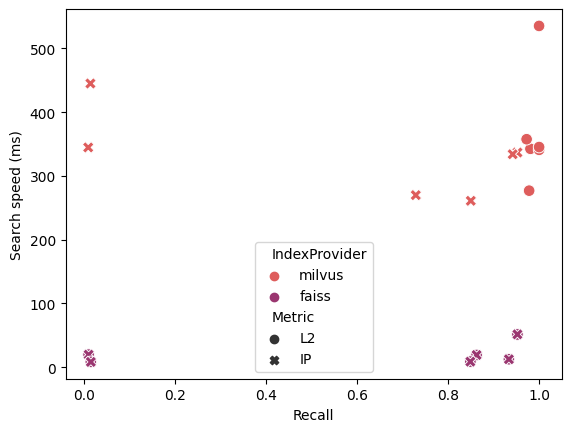

In [ ]:
df_plot = df_results.query("IndexType == 'IVF'")

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_plot,
    x="Recall avg",
    y="Search speed avg. (ms)",
    style="Metric",
    hue="IndexProvider",
    palette="flare",
    s=70,
)
plt.xlabel("Recall")
plt.ylabel("Search speed (ms)")
plt.show()

In [ ]:
df_plot

,Unnamed: 0,Dataset,Index,Index parameters.,Server startup speed (s),Index build speed (s),Search speed avg. (ms),Search speed p95 (ms),Recall avg,Recall@1,...,benchmarking_max,benchmarking_mean,IndexProvider,IndexType,Compression,M,Metric,ef_construction,ef_search,nPartitions
8,8,sift-128-euclidean,"index: milvus IVF, n_partition=100, None, L2","IVF, n_partition=100, None, L2",101.787549,67.694298,535.323174,652.183297,0.999900,0.998667,...,3479.866,1333.863717,milvus,IVF,None,NaN,L2,NaN,NaN,100
9,9,sift-128-euclidean,"index: milvus IVF, n_partition=100, None, IP","IVF, n_partition=100, None, IP",91.420860,67.650501,336.758641,452.926573,0.952370,0.942667,...,3675.376,1414.444104,milvus,IVF,None,NaN,IP,NaN,NaN,100
10,10,sift-128-euclidean,"index: milvus IVF, n_partition=800, None, L2","IVF, n_partition=800, None, L2",94.706829,97.900542,342.548977,450.795160,0.980920,0.994667,...,3164.188,1403.239169,milvus,IVF,None,NaN,L2,NaN,NaN,800
11,11,sift-128-euclidean,"index: milvus IVF, n_partition=800, None, IP","IVF, n_partition=800, None, IP",91.689105,116.726733,334.049765,450.846251,0.941887,0.938667,...,3226.744,1328.597447,milvus,IVF,None,NaN,IP,NaN,NaN,800
16,16,sift-128-euclidean,"index: faiss IVF, n_partition=100, None, L2","IVF, n_partition=100, None, L2",11.161616,1.657944,51.397209,58.086118,0.952310,0.940667,...,983.500,983.233333,faiss,IVF,None,NaN,L2,NaN,NaN,100
17,17,sift-128-euclidean,"index: faiss IVF, n_partition=100, None, IP","IVF, n_partition=100, None, IP",11.258433,1.707111,51.537080,58.806592,0.952310,0.940667,...,983.300,983.213333,faiss,IVF,None,NaN,IP,NaN,NaN,100
18,18,sift-128-euclidean,"index: faiss IVF, n_partition=800, None, L2","IVF, n_partition=800, None, L2",11.135456,11.343164,12.544496,14.577151,0.933587,0.935000,...,983.500,983.368000,faiss,IVF,None,NaN,L2,NaN,NaN,800
19,19,sift-128-euclidean,"index: faiss IVF, n_partition=800, None, IP","IVF, n_partition=800, None, IP",11.141454,11.405267,12.479163,14.724154,0.933587,0.935000,...,983.600,983.429630,faiss,IVF,None,NaN,IP,NaN,NaN,800
32,32,glove-25-angular,"index: milvus IVF, n_partition=100, None, L2","IVF, n_partition=100, None, L2",94.486438,112.496317,340.963626,352.704370,1.000000,1.000000,...,689.920,678.531186,milvus,IVF,None,NaN,L2,NaN,NaN,100
33,33,glove-25-angular,"index: milvus IVF, n_partition=100, None, IP","IVF, n_partition=100, None, IP",96.210198,72.518448,344.703333,354.398582,0.008627,0.000667,...,631.110,620.596500,milvus,IVF,None,NaN,IP,NaN,NaN,100


In [ ]:
df_plot = df_results.query("IndexType == 'IVF'")

# plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_plot,
    x="Recall avg",
    y="Search speed avg. (ms)",
    style="Metric",
    hue="nPartitions",
    palette="flare",
    s=70,
)
plt.xlabel("Recall")
plt.ylabel("Search speed (ms)")
plt.show()

In [ ]:
df_results.query("Dataset == ")